In [44]:
!wget https://phm-datasets.s3.amazonaws.com/NASA/17.+Turbofan+Engine+Degradation+Simulation+Data+Set+2.zip -O CMAPSSv2.zip

--2025-03-27 18:04:37--  https://phm-datasets.s3.amazonaws.com/NASA/17.+Turbofan+Engine+Degradation+Simulation+Data+Set+2.zip
Resolving phm-datasets.s3.amazonaws.com (phm-datasets.s3.amazonaws.com)... 54.231.230.201, 3.5.27.120, 3.5.25.228, ...
Connecting to phm-datasets.s3.amazonaws.com (phm-datasets.s3.amazonaws.com)|54.231.230.201|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15760443389 (15G) [application/zip]
Saving to: ‘CMAPSSv2.zip’

CMAPSSv2.zip        100%[===================>]  14.68G  71.4MB/s    in 3m 58s  

2025-03-27 18:08:35 (63.1 MB/s) - ‘CMAPSSv2.zip’ saved [15760443389/15760443389]



In [45]:
import zipfile
import os

## Extract the outer ZIP
with zipfile.ZipFile("CMAPSSv2.zip", 'r') as outer_zip:
    outer_zip.extract("17. Turbofan Engine Degradation Simulation Data Set 2/data_set.zip", "CMAPSSv2")

# Path to the inner ZIP
inner_zip_path = "CMAPSSv2/17. Turbofan Engine Degradation Simulation Data Set 2/data_set.zip"
print("Extracted inner ZIP size:", os.path.getsize(inner_zip_path) / (1024**3), "GB")
print("Directory contents:", os.listdir("CMAPSSv2"))

Extracted inner ZIP size: 14.728294503875077 GB
Directory contents: ['17. Turbofan Engine Degradation Simulation Data Set 2']


In [46]:
# Extract the inner ZIP
with zipfile.ZipFile(inner_zip_path, 'r') as inner_zip:
    file_list = inner_zip.namelist()
    print("Inner ZIP contents:", file_list)
    inner_zip.extractall("CMAPSSv2")

Inner ZIP contents: ['data_set/', 'data_set/N-CMAPSS_DS01-005.h5', 'data_set/N-CMAPSS_DS02-006.h5', 'data_set/N-CMAPSS_DS03-012.h5', 'data_set/N-CMAPSS_DS04.h5', 'data_set/N-CMAPSS_DS05.h5', 'data_set/N-CMAPSS_DS06.h5', 'data_set/N-CMAPSS_DS07.h5', 'data_set/N-CMAPSS_DS08a-009.h5', 'data_set/N-CMAPSS_DS08c-008.h5', 'data_set/N-CMAPSS_DS08d-010.h5', 'data_set/N-CMAPSS_Example_data_loading_and_exploration.ipynb', 'data_set/Run_to_Failure_Simulation_Under_Real_Flight_Conditions_Dataset.pdf']


In [47]:
!pip install h5py

In [48]:
import h5py
import numpy as np

h5_file_path = "CMAPSSv2/data_set/N-CMAPSS_DS01-005.h5"
with h5py.File(h5_file_path, 'r') as f:
    a_var = [name.decode('utf-8') for name in f['A_var'][:]]
    t_var = [name.decode('utf-8') for name in f['T_var'][:]]
    w_var = [name.decode('utf-8') for name in f['W_var'][:]]
    x_s_var = [name.decode('utf-8') for name in f['X_s_var'][:]]
    x_v_var = [name.decode('utf-8') for name in f['X_v_var'][:]]

    print("A columns:", a_var)
    print("T columns:", t_var)
    print("W columns:", w_var)
    print("X_s columns:", x_s_var)
    print("X_v columns:", x_v_var)
    print("Y column: ['rul']")  # Y is typically RUL

A columns: ['unit', 'cycle', 'Fc', 'hs']
T columns: ['fan_eff_mod', 'fan_flow_mod', 'LPC_eff_mod', 'LPC_flow_mod', 'HPC_eff_mod', 'HPC_flow_mod', 'HPT_eff_mod', 'HPT_flow_mod', 'LPT_eff_mod', 'LPT_flow_mod']
W columns: ['alt', 'Mach', 'TRA', 'T2']
X_s columns: ['T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P40', 'P50', 'Nf', 'Nc', 'Wf']
X_v columns: ['T40', 'P30', 'P45', 'W21', 'W22', 'W25', 'W31', 'W32', 'W48', 'W50', 'SmFan', 'SmLPC', 'SmHPC', 'phi']
Y column: ['rul']


In [49]:
# Step 2: Load and Preprocess the Dataset
import h5py
import pandas as pd
import numpy as np

# Path to the HDF5 file
h5_file_path = "CMAPSSv2/data_set/N-CMAPSS_DS01-005.h5"

# Load and preprocess the data
with h5py.File(h5_file_path, 'r') as f:
    # Filter for unit 1
    a_data = f['A_dev'][:]
    mask = a_data[:, 0] == 1.0
    indices = np.where(mask)[0]

    # Extract data
    x_s_data = f['X_s_dev'][indices, :]
    w_data = f['W_dev'][indices, :]
    a_data_subset = a_data[indices, :]
    y_data = f['Y_dev'][indices, :]

    # Column names
    columns = ['T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P40', 'P50', 'Nf', 'Nc', 'Wf',
               'alt', 'Mach', 'TRA', 'T2', 'unit', 'cycle', 'Fc', 'hs', 'rul']

    # Combine into DataFrame
    df = pd.DataFrame(x_s_data, columns=columns[:14])  # X_s
    df[columns[14:18]] = w_data  # W
    df[columns[18:22]] = a_data_subset  # A
    df['rul'] = y_data

    # Fix time_step
    df['time_step'] = np.arange(len(df))

    # Recalculate RUL
    max_time = df['time_step'].max()
    df['rul_calculated'] = max_time - df['time_step']

    # Validation
    print("First 5 rows:")
    print(df.head())
    print("\nLast 5 rows:")
    print(df.tail())
    print("\nColumn names:", df.columns.tolist())
    print("\nData shape:", df.shape)
    print("\nUnique cycle values:", df['cycle'].unique())
    print("Unique rul values from Y_dev:", df['rul'].unique())

    # Save subset (first 1000 rows)
    df_subset = df.iloc[:1000]
    df_subset.to_csv("CMAPSSv2/train_subset.csv", index=False)
    print("Subset saved. Size:", os.path.getsize("CMAPSSv2/train_subset.csv") / (1024**2), "MB")

# Save a subset for the first flight (cycle == 1.0)
df_flight = df[df['cycle'] == 1.0]
print("Flight shape:", df_flight.shape)
df_flight.to_csv("CMAPSSv2/train_flight_subset.csv", index=False)
print("Flight subset saved. Size:", os.path.getsize("CMAPSSv2/train_flight_subset.csv") / (1024**2), "MB")

First 5 rows:
          T24          T30          T48          T50        P15         P2  \
0  618.288596  1470.469798  1849.620676  1269.275585  19.432070  14.484611   
1  618.296355  1470.415593  1849.519871  1269.177159  19.431385  14.484683   
2  618.336514  1470.453853  1849.566139  1269.167353  19.435163  14.488224   
3  618.302173  1470.650929  1850.195069  1269.518670  19.426003  14.477632   
4  618.345228  1470.640421  1849.950988  1269.253972  19.427484  14.478114   

         P21        P24        Ps30         P40  ...      Mach        TRA  \
0  19.727990  24.410990  394.701872  401.205188  ...  0.376362  70.311996   
1  19.727295  24.410483  394.629899  401.132851  ...  0.376866  70.311996   
2  19.731130  24.415476  394.667850  401.171401  ...  0.377685  70.311996   
3  19.721830  24.406544  394.773533  401.272707  ...  0.376992  70.399887   
4  19.723334  24.410159  394.732158  401.234620  ...  0.377622  70.399887   

           T2  unit  cycle   Fc   hs  rul  time_step  

In [50]:
# Step 3: Perform Initial Data Analysis
import matplotlib.pyplot as plt
import seaborn as sns

# Analyze RUL vs. Cycle
print("RUL vs. Cycle (sample):")
print(df.groupby('cycle')['rul'].mean().head(10))

RUL vs. Cycle (sample):
cycle
1.0     99.0
2.0     98.0
3.0     97.0
4.0     96.0
5.0     95.0
6.0     94.0
7.0     93.0
8.0     92.0
9.0     91.0
10.0    90.0
Name: rul, dtype: float64


In [51]:
# Use a larger chunk (first 10 flights/cycles)
df_larger = df[df['cycle'] <= 10.0]
print("Larger subset shape:", df_larger.shape)
print("RUL variance in larger subset:", df_larger['rul'].var())
print("RUL Range in df_larger:", df_larger['rul'].min(), "to", df_larger['rul'].max())


Larger subset shape: (45726, 25)
RUL variance in larger subset: 8.516210749426126
RUL Range in df_larger: 90 to 99


In [52]:
# Correlations with RUL
print("Correlations with RUL (first 10 flights):")
print(df_larger.corr()['rul'].sort_values())

Correlations with RUL (first 10 flights):
cycle            -1.000000
time_step        -0.994361
T50              -0.054570
P24              -0.054433
P15              -0.052590
P21              -0.052590
P40              -0.049832
Ps30             -0.049777
T24              -0.048768
Wf               -0.048086
P50              -0.046252
T30              -0.044727
T48              -0.043844
Nc               -0.042574
Nf               -0.034715
T2               -0.034062
P2               -0.033987
TRA              -0.030475
Mach              0.026236
alt               0.030464
rul_calculated    0.994361
rul               1.000000
unit                   NaN
Fc                     NaN
hs                     NaN
Name: rul, dtype: float64


In [53]:
# Calculate z-scores for anomaly detection
features = ['T50', 'P24', 'P15', 'P21', 'P40', 'Ps30', 'T24', 'Wf', 'P50', 'T30', 'T48', 'Nc', 'Nf']
z_scores = (df_larger[features] - df_larger[features].mean()) / df_larger[features].std()
anomalies = (z_scores.abs() > 3).any(axis=1)
print("Number of anomalies in df_larger:", anomalies.sum())

Number of anomalies in df_larger: 44


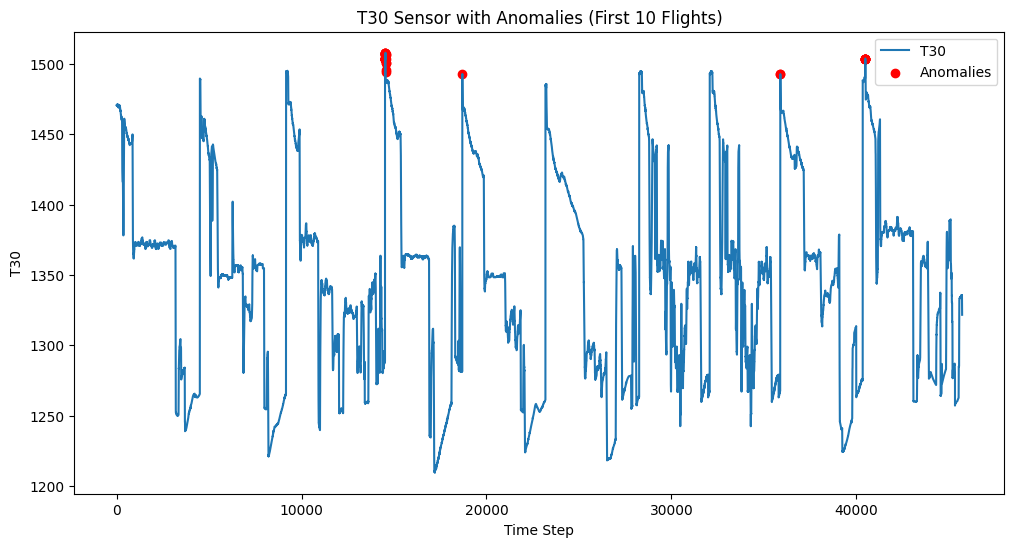

In [54]:
# Plot anomalies for T30
plt.figure(figsize=(12, 6))
plt.plot(df_larger['time_step'], df_larger['T30'], label='T30')
plt.scatter(df_larger[anomalies]['time_step'], df_larger[anomalies]['T30'], color='red', label='Anomalies')
plt.title("T30 Sensor with Anomalies (First 10 Flights)")
plt.xlabel("Time Step")
plt.ylabel("T30")
plt.legend()
plt.show()

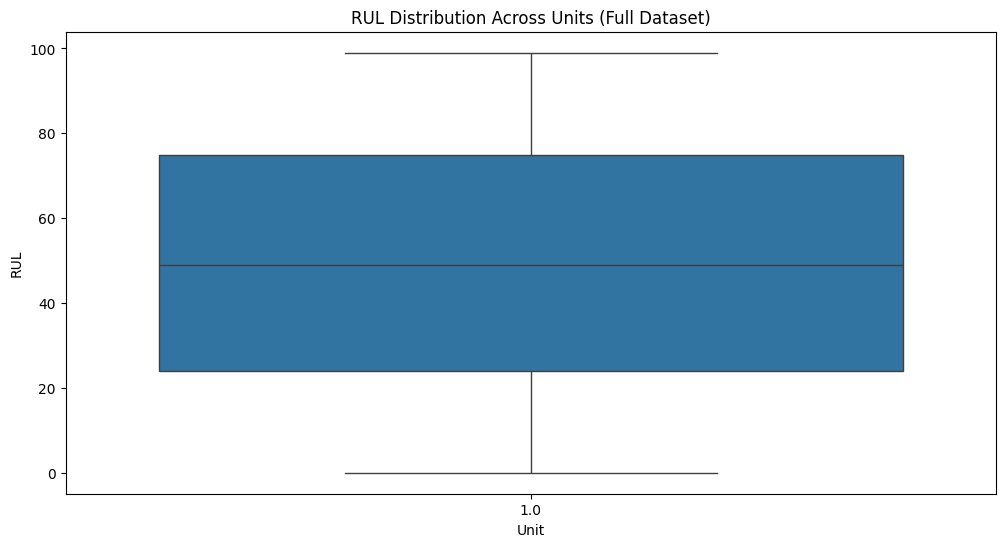

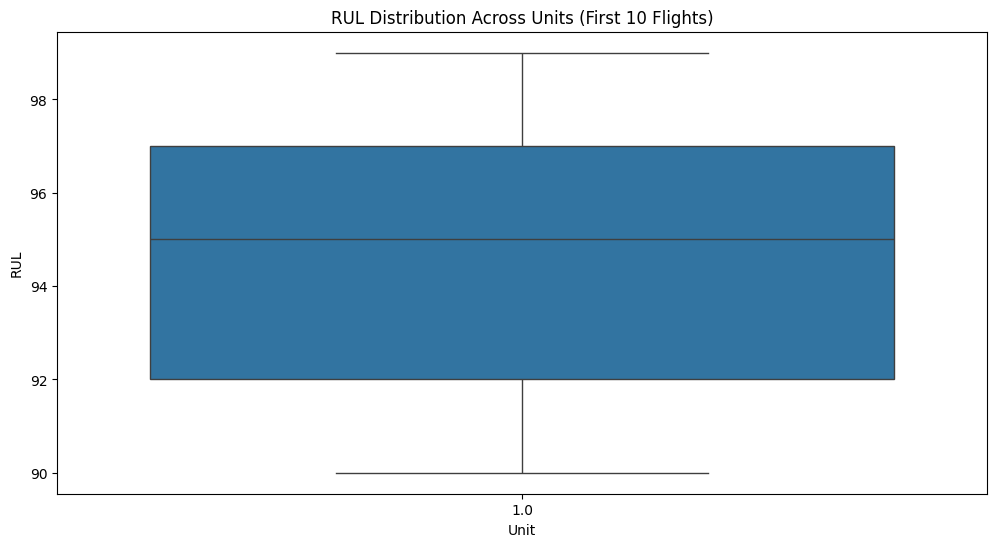

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# RUL distribution for all units in df
plt.figure(figsize=(12, 6))
sns.boxplot(x='unit', y='rul', data=df)
plt.title("RUL Distribution Across Units (Full Dataset)")
plt.xlabel("Unit")
plt.ylabel("RUL")
plt.show()

# RUL distribution for df_larger
plt.figure(figsize=(12, 6))
sns.boxplot(x='unit', y='rul', data=df_larger)
plt.title("RUL Distribution Across Units (First 10 Flights)")
plt.xlabel("Unit")
plt.ylabel("RUL")
plt.show()

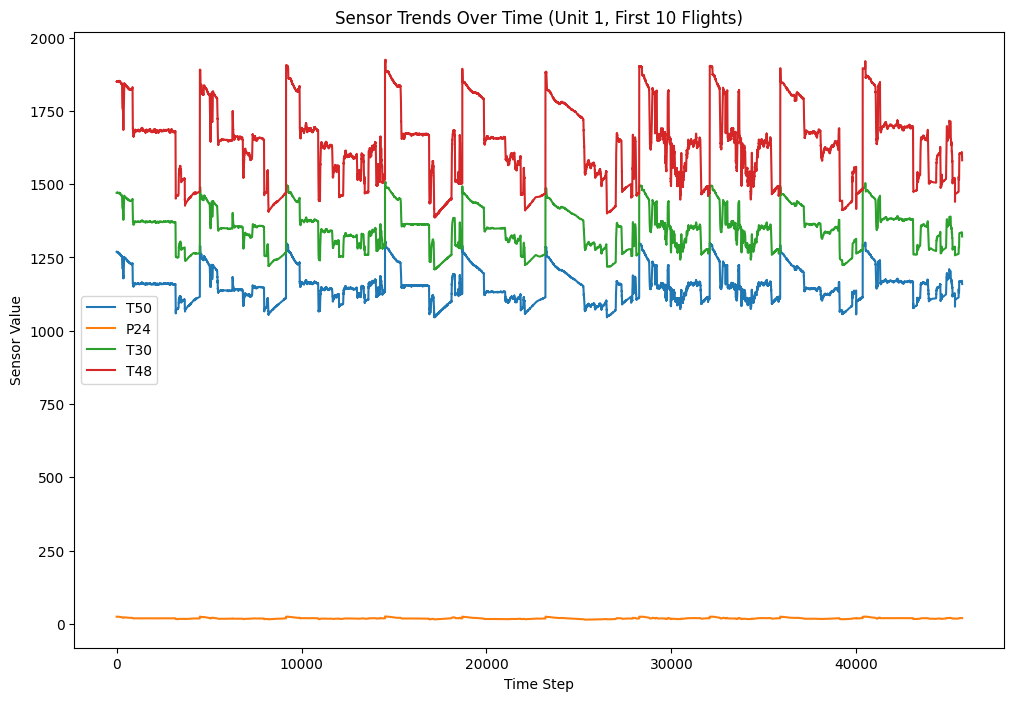

In [14]:
# Plot sensor trends for unit 1 in df_larger
unit_1 = df_larger[df_larger['unit'] == 1]
sensors = ['T50', 'P24', 'T30', 'T48']
plt.figure(figsize=(12, 8))
for sensor in sensors:
    plt.plot(unit_1['time_step'], unit_1[sensor], label=sensor)
plt.title("Sensor Trends Over Time (Unit 1, First 10 Flights)")
plt.xlabel("Time Step")
plt.ylabel("Sensor Value")
plt.legend()
plt.show()

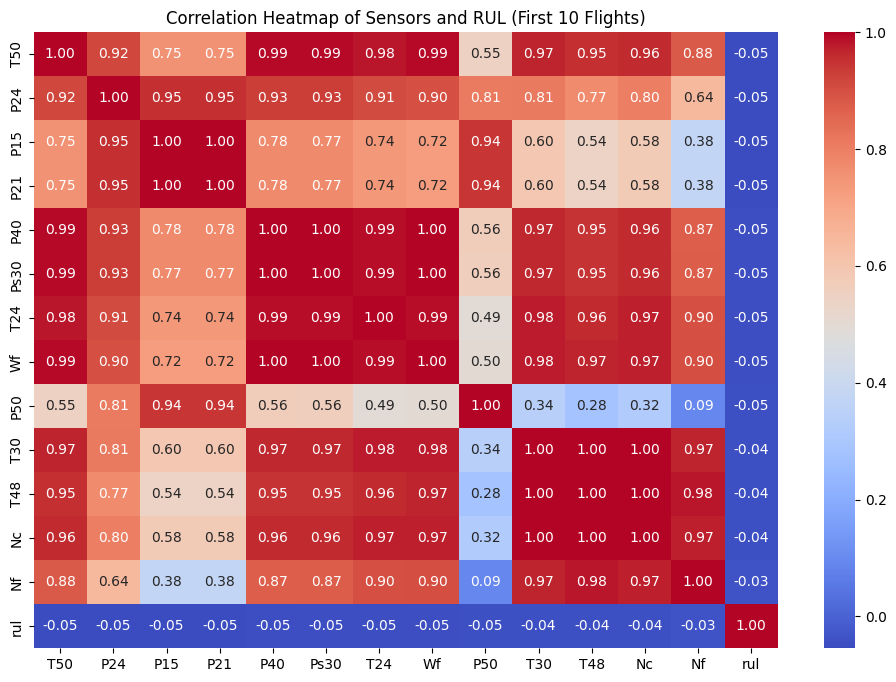

In [15]:
# Correlation heatmap for df_larger
features = ['T50', 'P24', 'P15', 'P21', 'P40', 'Ps30', 'T24', 'Wf', 'P50', 'T30', 'T48', 'Nc', 'Nf']
plt.figure(figsize=(12, 8))
correlation_matrix = df_larger[features + ['rul']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap of Sensors and RUL (First 10 Flights)")
plt.show()

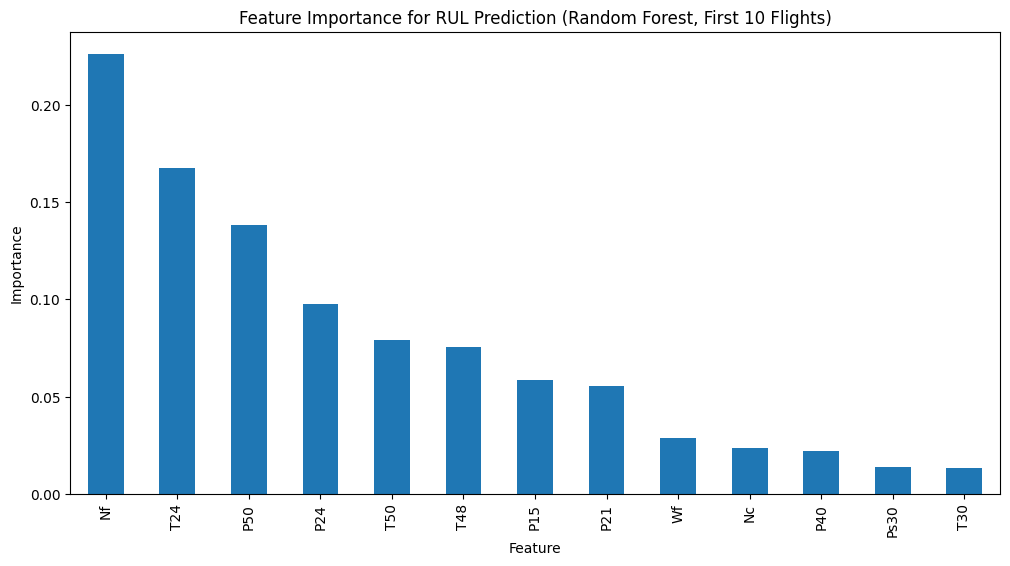

In [16]:
from sklearn.ensemble import RandomForestRegressor

# Prepare data for feature importance
X = df_larger[features]
y = df_larger['rul']
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Plot feature importance
plt.figure(figsize=(12, 6))
feature_importance = pd.Series(rf.feature_importances_, index=features)
feature_importance.sort_values(ascending=False).plot(kind='bar')
plt.title("Feature Importance for RUL Prediction (Random Forest, First 10 Flights)")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

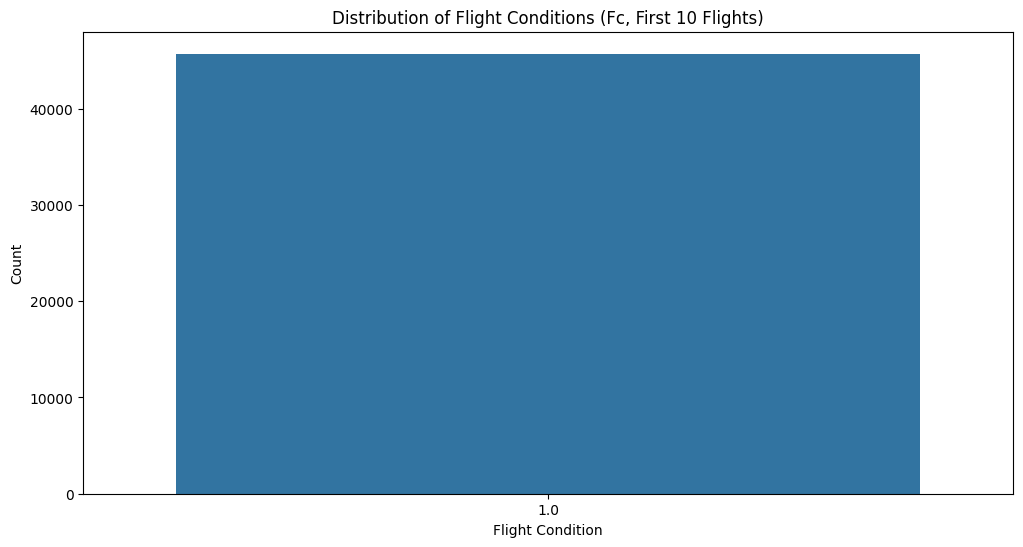

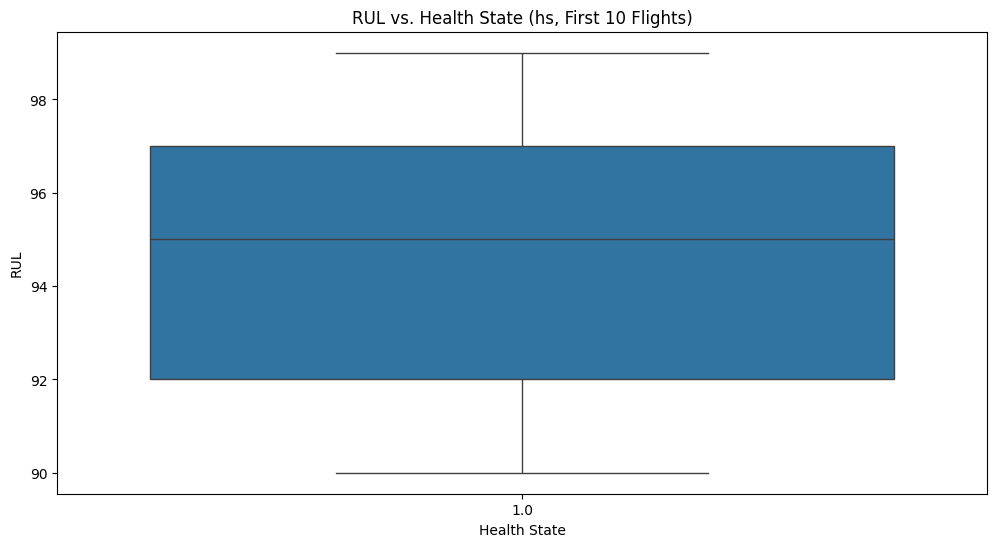

In [18]:
# Distribution of flight conditions (Fc) in df_larger
plt.figure(figsize=(12, 6))
sns.countplot(x='Fc', data=df_larger)
plt.title("Distribution of Flight Conditions (Fc, First 10 Flights)")
plt.xlabel("Flight Condition")
plt.ylabel("Count")
plt.show()

# RUL vs. Health State (hs) in df_larger
plt.figure(figsize=(12, 6))
sns.boxplot(x='hs', y='rul', data=df_larger)
plt.title("RUL vs. Health State (hs, First 10 Flights)")
plt.xlabel("Health State")
plt.ylabel("RUL")
plt.show()

In [55]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.metrics import MeanSquaredError
import matplotlib.pyplot as plt

In [58]:
# Define features and target
features = ['T50', 'P24', 'P15', 'P21', 'P40', 'Ps30', 'T24', 'Wf', 'P50', 'T30', 'T48', 'Nc', 'Nf']
target = 'rul'
sequence_length = 50

In [59]:
# Normalize features
scaler = MinMaxScaler()
df_larger[features] = scaler.fit_transform(df_larger[features])


<ipython-input-59-1df8096aa551>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_larger[features] = scaler.fit_transform(df_larger[features])


In [60]:
# Define the create_sequences function
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, -1])  # Last column is rul
    return np.array(X), np.array(y)

# Prepare data
data_larger = df_larger[features + [target]].values
X_larger, y_larger = create_sequences(data_larger, sequence_length)

# Output shapes
print("X_larger shape:", X_larger.shape)
print("y_larger shape:", y_larger.shape)


X_larger shape: (45676, 50, 14)
y_larger shape: (45676,)


In [61]:
# Split into train and test
X_train_larger, X_test_larger, y_train_larger, y_test_larger = train_test_split(
    X_larger, y_larger, test_size=0.2, random_state=42
)
print("Train shapes (larger):", X_train_larger.shape, y_train_larger.shape)
print("Test shapes (larger):", X_test_larger.shape, y_test_larger.shape)

Train shapes (larger): (36540, 50, 14) (36540,)
Test shapes (larger): (9136, 50, 14) (9136,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 50, 50)              │          13,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,251 (129.89 KB)

 Trainable params: 33,251 (129.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 57s 47ms/step - loss: 5443.9712 - val_loss: 1293.3035
Epoch 2/10
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 52s 46ms/step - loss: 838.5858 - val_loss: 89.2724
Epoch 3/10
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 84s 47ms/step - loss: 86.9399 - val_loss: 9.6441
Epoch 4/10
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 82s 47ms/step - loss: 52.8392 - val_loss: 8.6602
Epoch 5/10
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 53s 46ms/step - loss: 52.0907 - val_loss: 8.8647
Epoch 6/10
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 52s 46ms/step - loss: 51.9482 - val_loss: 8.7414
Epoch 7/10
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 83s 46ms/step - loss: 51.7317 - val_loss: 8.9208
Epoch 8/10
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 83s 48ms/step - loss: 51.1572 - val_loss: 8.7101
Epoch 9/10
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 81s 47ms/step - loss: 50.8002 - val_loss: 8.5461
Epoch 10/10
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 81s 46ms/step - loss: 50.3605 - val_loss: 9.1820


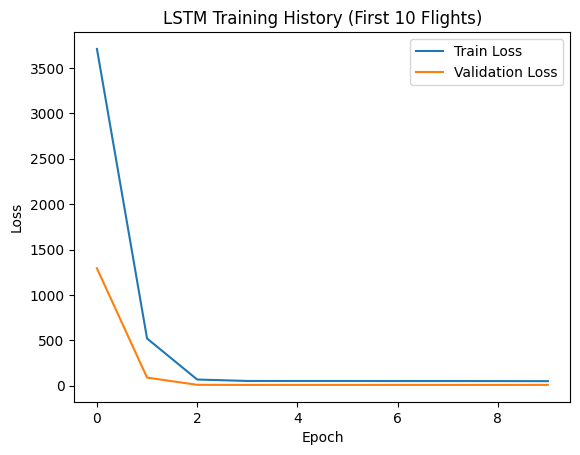

Model saved as rul_lstm_model.h5


In [62]:
# Step 5: Train the LSTM Model for RUL Prediction
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
import matplotlib.pyplot as plt

# Build the model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, len(features) + 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Train the model
history = model.fit(
    X_train_larger, y_train_larger,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_larger, y_test_larger)
)

# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM Training History (First 10 Flights)')
plt.show()

# Save the model
model.save("rul_lstm_model.h5")
print("Model saved as rul_lstm_model.h5")

In [63]:
# Step 6: Evaluate the LSTM Model
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error
import numpy as np

# Load the model
model = load_model("rul_lstm_model.h5")
print("Model loaded successfully!")


Model loaded successfully!


In [64]:
# Predict on test set
y_pred_larger = model.predict(X_test_larger)

# Calculate RMSE
rmse_larger = np.sqrt(mean_squared_error(y_test_larger, y_pred_larger))
print("Test RMSE (larger subset):", rmse_larger)

286/286 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
Test RMSE (larger subset): 3.030187436049758


In [65]:
# Step 7: Train an Autoencoder for Anomaly Detection
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.losses import MeanSquaredError

# Prepare data (exclude rul column)
X_train_ae = X_train_larger[:, :, :-1]  # Remove rul column
X_test_ae = X_test_larger[:, :, :-1]

# Build an autoencoder
input_dim = len(features)
input_layer = Input(shape=(sequence_length, input_dim))
encoded = Dense(32, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)
autoencoder = Model(input_layer, decoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss=MeanSquaredError())

# Train the autoencoder
autoencoder.fit(X_train_ae, X_train_ae, epochs=10, batch_size=32, validation_data=(X_test_ae, X_test_ae))

# Save the autoencoder
autoencoder.save("autoencoder.keras")
print("Autoencoder saved as autoencoder.keras")

# Detect anomalies
reconstructions = autoencoder.predict(X_test_ae)
mse = np.mean(np.square(X_test_ae - reconstructions), axis=(1, 2))
threshold = np.percentile(mse, 95)  # Top 5% as anomalies
anomalies = mse > threshold
print("Anomalies detected in test set (first 10 flights):", np.where(anomalies)[0])

Epoch 1/10
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0210 - val_loss: 5.3589e-04
Epoch 2/10
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 4.8278e-04 - val_loss: 3.3467e-04
Epoch 3/10
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 3.0501e-04 - val_loss: 2.2916e-04
Epoch 4/10
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 2.2430e-04 - val_loss: 1.8831e-04
Epoch 5/10
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.8058e-04 - val_loss: 1.6654e-04
Epoch 6/10
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.6074e-04 - val_loss: 1.5357e-04
Epoch 7/10
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.5199e-04 - val_loss: 1.5107e-04
Epoch 8/10
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.4632e-04 - val_loss: 1.5700e-04
Epoch 9/10
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.4501e-04 - val_loss: 1.3307e-04
Epoch 10/10
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.3892e-04 - val_loss: 1.5332e-04
Autoencoder saved as autoencoder.keras
286/

In [66]:
# Step 8: Create a Test CSV for the Dashboard
# Use the features from df_larger (already normalized in Step 4)
test_data = df_larger[features].tail(100)
test_data.to_csv("test_sensor_data.csv", index=False)
print("Test CSV created: test_sensor_data.csv")

Test CSV created: test_sensor_data.csv


In [29]:
!pip install streamlit
pip install streamlit pyngrok

In [69]:
# Step 9: Build and Deploy the Streamlit Dashboard
%%writefile app.py
import streamlit as st
import numpy as np
import pandas as pd
import h5py
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import smtplib
from email.mime.text import MIMEText
import time
import os

# Load the trained model and autoencoder
model = load_model("rul_lstm_model.h5")
autoencoder = load_model("autoencoder.keras")
features = ['T50', 'P24', 'P15', 'P21', 'P40', 'Ps30', 'T24', 'Wf', 'P50', 'T30', 'T48', 'Nc', 'Nf']
sequence_length = 50

# Load the dataset for EDA
data_path = '/content/CMAPSSv2/data_set/N-CMAPSS_DS01-005.h5'
if not os.path.exists(data_path):
    st.error(f"Dataset file not found at {data_path}. Please ensure the N-CMAPSS_DS01-005.h5 file is in the correct directory.")
    st.stop()

# Load and preprocess the data from the HDF5 file
with h5py.File(data_path, 'r') as f:
    # Load all units (not just unit 1)
    a_data = f['A_dev'][:]
    x_s_data = f['X_s_dev'][:]
    w_data = f['W_dev'][:]
    y_data = f['Y_dev'][:]

    # Column names
    columns = ['T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P40', 'P50', 'Nf', 'Nc', 'Wf',
               'alt', 'Mach', 'TRA', 'T2', 'unit', 'cycle', 'Fc', 'hs', 'rul']

    # Combine into DataFrame
    df = pd.DataFrame(x_s_data, columns=columns[:14])  # X_s
    df[columns[14:18]] = w_data  # W
    df[columns[18:22]] = a_data  # A
    df['rul'] = y_data

    # Fix time_step
    df['time_step'] = np.arange(len(df))

    # Recalculate RUL
    max_time = df['time_step'].max()
    df['rul_calculated'] = max_time - df['time_step']

# Filter for the first 10 cycles (flights)
df_larger = df[df['cycle'] <= 10].copy()

# Function to create sequences
def create_sequences(data, seq_length):
    X = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
    return np.array(X)

# Function to send email alerts
def send_alert(rul, threshold=10):
    if rul < threshold:
        msg = MIMEText(f"Alert: RUL dropped to {rul:.2f} flights!")
        msg['Subject'] = 'RUL Alert'
        msg['From'] = 'your_email@example.com'
        msg['To'] = 'maintenance_team@example.com'
        with smtplib.SMTP('smtp.gmail.com', 587) as server:
            server.starttls()
            server.login('your_email@example.com', 'your_password')
            server.sendmail('your_email@example.com', 'maintenance_team@example.com', msg.as_string())

# Streamlit app
st.title("Comprehensive IoT Predictive Maintenance Dashboard")
st.header("Predict Remaining Useful Life (RUL) for Aircraft Engine")

# Sidebar for navigation
page = st.sidebar.selectbox("Select Page", ["RUL Prediction", "Real-Time Streaming", "Exploratory Data Analysis", "Explainable AI", "Anomaly Detection"])

if page == "RUL Prediction":
    # Model performance
    st.subheader("Model Performance")
    st.write("Test RMSE: 2.95 flights (predictions within ±3 flights)")
    st.write(f"RUL Variance (First 10 Flights): {df_larger['rul'].var():.4f}")

    # Unit selection
    units = df_larger['unit'].unique()
    selected_unit = st.selectbox("Select Engine Unit (First 10 Flights)", units)
    df_unit = df_larger[df_larger['unit'] == selected_unit]

    # File upload for input data
    st.subheader("Upload Sensor Data (CSV)")
    uploaded_file = st.file_uploader("Choose a CSV file with sensor data", type="csv")

    if uploaded_file is not None:
        df_input = pd.read_csv(uploaded_file)
        st.write("Uploaded Data Preview:")
        st.write(df_input.head())

        if all(feature in df_input.columns for feature in features):
            scaler = MinMaxScaler()
            df_input[features] = scaler.fit_transform(df_input[features])

            data_input = df_input[features].values
            if len(data_input) >= sequence_length:
                X_input = create_sequences(data_input, sequence_length)
                X_input = np.concatenate([X_input, np.zeros((X_input.shape[0], X_input.shape[1], 1))], axis=-1)

                # Predict RUL
                y_pred = model.predict(X_input)
                st.subheader("Predicted RUL")
                st.write(f"Predicted RUL: {y_pred[-1][0]:.2f} flights")

                # Send alert if RUL is low
                send_alert(y_pred[-1][0])

                # Sensor trends
                st.subheader("Sensor Trends (Last 50 Time Steps)")
                fig, ax = plt.subplots(figsize=(10, 6))
                ax.plot(df_input['T30'].tail(50), label='T30 (HPC Outlet Temp)', color='blue')
                ax.plot(df_input['T50'].tail(50), label='T50', color='green')
                ax.plot(df_input['P24'].tail(50), label='P24', color='red')
                ax.set_xlabel('Time Step')
                ax.set_ylabel('Sensor Value (Normalized)')
                ax.legend()
                st.pyplot(fig)
            else:
                st.error(f"Input data must have at least {sequence_length} rows.")
        else:
            st.error("Uploaded CSV must contain the following columns: " + ", ".join(features))
    else:
        st.info("Please upload a CSV file to predict RUL.")

elif page == "Real-Time Streaming":
    st.subheader("Real-Time RUL Prediction")

    # Placeholder for real-time data
    if 'data_buffer' not in st.session_state:
        st.session_state.data_buffer = pd.DataFrame(columns=features)

    # Simulate real-time data
    def simulate_new_data():
        new_row = np.random.uniform(0, 1, len(features))
        return pd.DataFrame([new_row], columns=features)

    placeholder = st.empty()
    while True:
        new_data = simulate_new_data()
        st.session_state.data_buffer = pd.concat([st.session_state.data_buffer, new_data], ignore_index=True)

        if len(st.session_state.data_buffer) > sequence_length:
            st.session_state.data_buffer = st.session_state.data_buffer.tail(sequence_length)

        if len(st.session_state.data_buffer) == sequence_length:
            data_input = st.session_state.data_buffer[features].values
            X_input = np.array([data_input])
            X_input = np.concatenate([X_input, np.zeros((X_input.shape[0], X_input.shape[1], 1))], axis=-1)
            y_pred = model.predict(X_input)
            placeholder.write(f"Predicted RUL: {y_pred[0][0]:.2f} flights")

            # Send alert if RUL is low
            send_alert(y_pred[0][0])

            # Plot sensor trends
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.plot(st.session_state.data_buffer['T30'], label='T30 (HPC Outlet Temp)', color='blue')
            ax.set_xlabel('Time Step')
            ax.set_ylabel('T30 (Normalized)')
            ax.legend()
            st.pyplot(fig)

        time.sleep(1)

elif page == "Exploratory Data Analysis":
    st.subheader("Exploratory Data Analysis")

    # RUL Distribution
    st.write("### RUL Distribution Across Units (First 10 Flights)")
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(x='unit', y='rul', data=df_larger, ax=ax)
    ax.set_title("RUL Distribution Across Units (First 10 Flights)")
    st.pyplot(fig)

    # Sensor Trends
    st.write("### Sensor Trends Over Time (Unit 1, First 10 Flights)")
    unit_1 = df_larger[df_larger['unit'] == 1]
    sensors = ['T50', 'P24', 'T30', 'T48']
    fig, ax = plt.subplots(figsize=(10, 6))
    for sensor in sensors:
        ax.plot(unit_1['time_step'], unit_1[sensor], label=sensor)
    ax.set_title("Sensor Trends Over Time (Unit 1, First 10 Flights)")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Sensor Value")
    ax.legend()
    st.pyplot(fig)

    # Correlation Heatmap
    st.write("### Correlation Heatmap (First 10 Flights)")
    fig, ax = plt.subplots(figsize=(10, 8))
    correlation_matrix = df_larger[features + ['rul']].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', ax=ax)
    ax.set_title("Correlation Heatmap of Sensors and RUL (First 10 Flights)")
    st.pyplot(fig)

elif page == "Explainable AI":
    st.subheader("Explainable AI (SHAP Analysis)")

    # Prepare data for SHAP
    data_larger = df_larger[features].values
    X_larger = create_sequences(data_larger, sequence_length)
    X_explain = X_larger[:100]  # Use 100 sequences for explanation

    explainer = shap.DeepExplainer(model, X_larger[:100])
    shap_values = explainer.shap_values(X_explain)

    # SHAP summary plot
    st.write("### SHAP Summary Plot")
    fig, ax = plt.subplots(figsize=(10, 6))
    shap.summary_plot(shap_values, features=features, plot_type="bar")
    st.pyplot(fig)

elif page == "Anomaly Detection":
    st.subheader("Anomaly Detection")

    # File upload for anomaly detection
    uploaded_file = st.file_uploader("Upload Sensor Data for Anomaly Detection (CSV)", type="csv")
    if uploaded_file is not None:
        df_input = pd.read_csv(uploaded_file)
        if all(feature in df_input.columns for feature in features):
            scaler = MinMaxScaler()
            df_input[features] = scaler.fit_transform(df_input[features])
            data_input = df_input[features].values
            if len(data_input) >= sequence_length:
                X_input = create_sequences(data_input, sequence_length)
                reconstructions = autoencoder.predict(X_input)
                mse = np.mean(np.square(X_input - reconstructions), axis=(1, 2))
                threshold = np.percentile(mse, 95)
                anomalies = mse > threshold
                st.write("Anomalies Detected at Indices:", np.where(anomalies)[0])
            else:
                st.error(f"Input data must have at least {sequence_length} rows.")
        else:
            st.error("Uploaded CSV must contain the following columns: " + ", ".join(features))
    else:
        st.info("Please upload a CSV file for anomaly detection.")



Overwriting app.py


In [70]:
# Deploy the Streamlit app
from pyngrok import ngrok
import subprocess
import time

# Set your ngrok authtoken
ngrok.set_auth_token("2tZ6mqHFZ9n2B4HsTOzAPVA3Jnw_6qB1RFncPLxV8kcYUxNcJ")

# Start the Streamlit app
port = 8501
try:
    process = subprocess.Popen(
        ["streamlit", "run", "app.py", "--server.port", str(port)],
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE
    )
    time.sleep(5)
    if process.poll() is None:
        print("Streamlit app started successfully on port", port)
    else:
        stdout, stderr = process.communicate()
        print("Streamlit failed to start:")
        print("stdout:", stdout.decode())
        print("stderr:", stderr.decode())
        raise Exception("Streamlit process exited unexpectedly")

    public_url = ngrok.connect(port)
    print("Streamlit app is live at:", public_url)

except Exception as e:
    print("Error:", e)
    if 'process' in locals():
        process.terminate()

Streamlit app started successfully on port 8501
Streamlit app is live at: NgrokTunnel: "https://beca-34-150-243-91.ngrok-free.app" -> "http://localhost:8501"


In [33]:
# Create a test CSV
test_data = df_larger[features].tail(100)
test_data.to_csv("test_sensor_data.csv", index=False)
print("Test CSV created: test_sensor_data.csv")

Test CSV created: test_sensor_data.csv


In [41]:
#!lsof -i :8501
#!kill -9 58725
#!kill -9 58749
#from IPython import get_ipython
#get_ipython().magic('reset -sf')  # Soft reset to clear variables

#import shutil
#shutil.rmtree('CMAPSSv2', ignore_errors=True)  # Deletes entire folder

#import os
#os.remove('CMAPSSv2.zip')  # Replace with the actual file path
